# Association analysis imputed data

Do the association analysis for the Hearing impairment traits with the white european individuals present in the 500K samples

## Columbia's cluster

In [1]:
# Common variables Columbia's cluster
UKBB_PATH=$HOME/UKBiobank
UKBB_yale=$HOME/UKBiobank_Yale_transfer
USER_PATH=$HOME/project
container_lmm=$HOME/containers/lmm.sif
container_marp=$HOME/containers/marp.sif
container_annovar=$HOME/containers/gatk4-annovar.sif
hearing_pheno_path=$UKBB_PATH/phenotype_files/hearing_impairment
tpl_file=$USER_PATH/bioworkflows/admin/csg.yml
formatFile_fastgwa=$USER_PATH/UKBB_GWAS_dev/data/fastGWA_template.yml
formatFile_bolt=$USER_PATH/UKBB_GWAS_dev/data/boltlmm_template.yml
formatFile_saige=$USER_PATH/UKBB_GWAS_dev/data/saige_template.yml
formatFile_regenie=$USER_PATH/UKBB_GWAS_dev/data/regenie_template.yml

/home/dmc2245/miniconda3/lib/python3.8/site-packages/sos_notebook/kernel.py:1334: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  msg['msg_id'] = self._parent_header['header']['msg_id']


## Shared variables for workflows and results

In [2]:
# Workflows
lmm_sos=$USER_PATH/bioworkflows/GWAS/LMM.ipynb
anno_sos=$USER_PATH/bioworkflows/variant-annotation/annovar.ipynb
clumping_sos=$USER_PATH/bioworkflows/GWAS/LD_Clumping.ipynb
extract_sos=$USER_PATH/bioworkflows/GWAS/Region_Extraction.ipynb
snptogene_sos=$USER_PATH/UKBB_GWAS_dev/workflow/snptogene.ipynb

# LMM directories for imputed data
lmm_imp_dir_fastgwa=$UKBB_PATH/results/FastGWA_results/results_imputed_data
lmm_imp_dir_bolt=$UKBB_PATH/results/BOLTLMM_results/results_imputed_data
lmm_imp_dir_saige=$UKBB_PATH/results/SAIGE_results/results_imputed_data
lmm_imp_dir_regenie=$UKBB_PATH/results/REGENIE_results/results_imputed_data

# LMM directories for exome data
lmm_exome_dir_fastgwa=$UKBB_PATH/results/FastGWA_results/results_exome_data
lmm_exome_dir_bolt=$UKBB_PATH/results/BOLTLMM_results/results_exome_data
lmm_exome_dir_saige=$UKBB_PATH/results/SAIGE_results/results_exome_data
lmm_exome_dir_regenie=$UKBB_PATH/results/REGENIE_results/results_exome_data

In [3]:
## LMM variables 
## Specific to Bolt_LMM
LDscoresFile=$UKBB_PATH/LDSCORE.1000G_EUR.tab.gz
geneticMapFile=$UKBB_PATH/genetic_map_hg19_withX.txt.gz
covarMaxLevels=10
numThreads=20
bgenMinMAF=0.001
bgenMinINFO=0.8
lmm_job_size=1
ylim=0

### Specific to FastGWA (depeding if you run from Yale or Columbia)
####Yale's cluster
grmFile=$UKBB_PATH/results/FastGWA_results/results_imputed_data/UKB_Caucasians_phenotypeindepqc120319_updated020720removedwithdrawnindiv.grm.sp
####Columbia's cluster
grmFile=$UKBB_yale/results/FastGWA_results/results_imputed_data/UKB_Caucasians_phenotypeindepqc120319_updated020720removedwithdrawnindiv.grm.sp

### Specific to SAIGE
bgenMinMAC=4
trait_type=binary
loco=TRUE
sampleCol=IID

### Specific to REGENIE
bsize=1000
lowmem=$HOME/scratch60/
lowmem_dir=$HOME/scratch60/predictions
trait=bt
minMAC=4
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
reverse_log_p=True

## Subset the individuals that passed the genotype QC from the ukb47922 data

### Subseting with mind 99%

In [2]:
%save /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_500K_callrate99.R -f
setwd('/mnt/mfs/statgen/UKBiobank/phenotype_files/HI_UKBB')
source("/mnt/mfs/statgen/UKBiobank/data/ukbb_databases/ukb47922_updatedAug2021/ukb47922.r")
print('Finished loading database')
nrow(bd)
## Use the fam file from the QC'ed genotype data with N=436,698 using mind=0.01
df.geno <- read.table("/mnt/mfs/statgen/UKBiobank/genotype_files_processed/083021_sample_variant_qc_final/cache/UKB_genotypedatadownloaded083019.083021_sample_variant_qc_final.filtered.extracted.fam", header=FALSE, stringsAsFactors = FALSE)
names(df.geno) <-c("FID","IID","ignore1", "ignore2", "ignore3", "ignore4")
nrow(df.geno)
head(bd[,1, drop=FALSE])
names(bd)[1] <- "IID"
head(bd[,1, drop=FALSE])
df.gen.phen <-merge(df.geno, bd, by="IID", all=FALSE)
print('Subsetting of the database completed')
nrow(df.gen.phen)
write.csv(df.gen.phen,'092821_UKBB_436698ind.csv', row.names = FALSE)
print('Finished writing the csv file')

Cell content saved to /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_500K.R, use option -r to also execute the cell.

In [3]:
%save /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_500K.sh -f
#!/bin/sh
#$ -l h_rt=36:00:00
#$ -l h_vmem=200G
#$ -N subset_ukb47922
#$ -o /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_$JOB_ID.out
#$ -e /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_$JOB_ID.err
#$ -j y
#$ -q csg.q
#$ -S /bin/bash
export PATH=$HOME/miniconda3/bin:$PATH
module load Singularity/3.5.3
module load R/4.0
Rscript /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_500K.R

Cell content saved to /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_500K.sh, use option -r to also execute the cell.

### Subsetting with mind 90%

In [4]:
%save /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_500K_callrate90.R -f
setwd('/mnt/mfs/statgen/UKBiobank/phenotype_files/HI_UKBB')
source("/mnt/mfs/statgen/UKBiobank/data/ukbb_databases/ukb47922_updatedAug2021/ukb47922.r")
print('Finished loading database')
nrow(bd)
## Use the fam file from the QC'ed genotype data with N=486,416 using mind=0.1
df.geno <- read.table("/mnt/mfs/statgen/UKBiobank/genotype_files_processed/090221_sample_variant_qc_final_callrate90/cache/UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.fam", header=FALSE, stringsAsFactors = FALSE)
names(df.geno) <-c("FID","IID","ignore1", "ignore2", "ignore3", "ignore4")
nrow(df.geno)
head(bd[,1, drop=FALSE])
names(bd)[1] <- "IID"
head(bd[,1, drop=FALSE])
df.gen.phen <-merge(df.geno, bd, by="IID", all=FALSE)
print('Subsetting of the database completed')
nrow(df.gen.phen)
write.csv(df.gen.phen,'092821_UKBB_486416ind_call90.csv', row.names = FALSE)
print('Finished writing the csv file')

Cell content saved to /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_500K_callrate90.R, use option -r to also execute the cell.

In [5]:
%save /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_500K_call90.sh -f
#!/bin/sh
#$ -l h_rt=36:00:00
#$ -l h_vmem=200G
#$ -N subset_ukb47922_call90
#$ -o /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_call90_$JOB_ID.out
#$ -e /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_call90_$JOB_ID.err
#$ -j y
#$ -q csg.q
#$ -S /bin/bash
export PATH=$HOME/miniconda3/bin:$PATH
module load Singularity/3.5.3
module load R/4.0
Rscript /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_500K_callrate90.R

Cell content saved to /home/dmc2245/project/UKBB_GWAS_dev/output/subset_ukb47922_500K_call90.sh, use option -r to also execute the cell.

## Run hearing_impairment notebook to get the white Europeans for PCA

After running the notebook `092821_hearing_impairment_500K.ipynb` this file is generated to run the PCA analysis

"/mnt/mfs/statgen/UKBiobank/phenotype_files/HI_UKBB/ukb47922_white_460649ind.pheno" these are the ancestry phenotypes

"/mnt/mfs/statgen/UKBiobank/phenotype_files/HI_UKBB/ukb47922_white_460649ind.keep_id" these are the IID to keep

## Run PCA analysis for the whole sample of white Europeans

### 09-28-21 PCA with QC'ed genotype array data

#### Step 1. Select European individuals form the genotype data

In [4]:
#Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/white_europeans
#bfile with sample and variants QC from 083021 containing all of the samples Columbias's cluster
##here I used the bfile in which individuals with call rate >90% were retained
genoFile=~/UKBiobank/genotype_files_processed/090221_sample_variant_qc_final_callrate90/cache/UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.bed
#To keep the samples of white individuals only
keep_samples=~/UKBiobank/phenotype_files/HI_UKBB/ukb47922_white_460649ind.keep_id
#QC is already done, so no need to filter any more
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
mem='30G'
gwasqc_sos=$USER_PATH/bioworkflows/GWAS/GWAS_QC.ipynb
gwasqc_sbatch=$USER_PATH/UKBB_GWAS_dev/output/select_white_europeans_500K_$(date +"%Y-%m-%d").sbatch

gwasqc1_args="""qc:1
    --cwd $cwd
    --genoFile $genoFile
    --keep_samples $keep_samples
    --maf_filter $maf_filter
    --geno_filter $geno_filter
    --hwe_filter $hwe_filter
    --mind_filter $mind_filter
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
    --mem $mem
"""

sos run ~/project/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $gwasqc_sos \
    --to-script $gwasqc_sbatch \
    --args "$gwasqc1_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/dmc2245/project/UKBB_GWAS_dev/output/select_white_europeans_500K_2021-09-28.sbatch
INFO: Workflow csg (ID=w88641f4bec37ee3f) is executed successfully with 1 completed step.


#### Step 2. Run KING

In [7]:
##Columbia's variables
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_king
genoFile=$UKBB_PATH/results/092821_PCA_results_500K/white_europeans/cache/UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.white_europeans.filtered.bed
king_sbatch=$USER_PATH/UKBB_GWAS_dev/output/flashpca_king_extendedwhite_500K_$(date +"%Y-%m-%d").sbatch
kinship=0.0625
gwasqc_sos=$USER_PATH/bioworkflows/GWAS/GWAS_QC.ipynb
numThreads=20
mem='30G'
walltime='36h'

king_args="""king
    --cwd $cwd
    --genoFile $genoFile
    --kinship $kinship
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
    --mem $mem
    --walltime $walltime
    --no-maximize-unrelated
"""

sos run ~/project/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $gwasqc_sos \
    --to-script $king_sbatch \
    --args "$king_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/dmc2245/project/UKBB_GWAS_dev/output/flashpca_king_extendedwhite_500K_2021-09-28.sbatch
INFO: Workflow csg (ID=w5327bc6b64d3eeb2) is executed successfully with 1 completed step.


#### Remove related individuals and LD pruning

In [5]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_ldprun_unrelated
## Use the qc version of the genotype array with the already filtered 189010 white individuals
genoFile=$UKBB_PATH/results/092821_PCA_results_500K/white_europeans/cache/*.filtered.bed
#To keep the samples of related white individuals only
remove_samples=$UKBB_PATH/results/092821_PCA_results_500K/092821_king/*.related_id
gwasqc_sos=$USER_PATH/bioworkflows/GWAS/GWAS_QC.ipynb
#GWAS QC variables: leave all the variables in 0 so there's no more filtering in the already filtered data
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
#LD prunning variables
window=50
shift=10
r2=0.1
gwas_sbatch=$USER_PATH/UKBB_GWAS_dev/output/gwas_unrelated_european_$(date +"%Y-%m-%d").sbatch
numThreads=20
mem='30G'
job_size=1 

gwasqc_args="""qc
    --cwd $cwd
    --genoFile $genoFile
    --remove_samples $remove_samples
    --maf_filter $maf_filter
    --geno_filter $geno_filter
    --hwe_filter $hwe_filter
    --mind_filter $mind_filter
    --window $window
    --shift $shift
    --r2 $r2
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
    --mem $mem
"""

sos run ~/project/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $gwasqc_sos \
    --to-script $gwas_sbatch \
    --args "$gwasqc_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/dmc2245/project/UKBB_GWAS_dev/output/gwas_unrelated_european_2021-10-04.sbatch
INFO: Workflow csg (ID=w713cbba77182dcca) is executed successfully with 1 completed step.



#### Get bed file for related

In [8]:
##Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_ldprun_related
genoFile=$UKBB_PATH/results/092821_PCA_results_500K/white_europeans/cache/*.filtered.bed
keep_samples=$UKBB_PATH/results/092821_PCA_results_500K/092821_king/*.related_id
keep_variants=$UKBB_PATH/results/092821_PCA_results_500K/092821_ldprun_unrelated/cache/*.prune.in

#GWAS QC variables
maf_filter=0.0
geno_filter=0.0
hwe_filter=0.0
mind_filter=0.0
gwas_sbatch=$USER_PATH/UKBB_GWAS_dev/output/gwas_related_white_european_$(date +"%Y-%m-%d").sbatch
numThreads=20
mem='30G'
job_size=1

gwasqc_args="""qc:1
    --cwd $cwd
    --genoFile $genoFile
    --keep_samples $keep_samples
    --keep_variants $keep_variants
    --maf_filter $maf_filter
    --geno_filter $geno_filter
    --hwe_filter $hwe_filter
    --mind_filter $mind_filter
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
    --mem $mem
"""

sos run ~/project/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $gwasqc_sos \
    --to-script $gwas_sbatch \
    --args "$gwasqc_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/dmc2245/project/UKBB_GWAS_dev/output/gwas_related_white_european_2021-10-04.sbatch
INFO: Workflow csg (ID=w674b8286f47fe9f5) is executed successfully with 1 completed step.



#### Run PCA with unrelated

In [11]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_PCA_unrelated
#This is the bfile originated after filtering unrelated individuals and pruning
genoFile=$UKBB_PATH/results/092821_PCA_results_500K/092821_ldprun_unrelated/cache/*.prune.bed
phenoFile=$UKBB_PATH/phenotype_files/HI_UKBB/ukb47922_white_460649ind.pheno
label_col=ethnicity
pop_col=ethnicity
pca_sbatch=$USER_PATH/UKBB_GWAS_dev/output/flashpca_white_european_unrelated_$(date +"%Y-%m-%d").sbatch
k=10
maha_k=10
min_axis=0
max_axis=0
job_size=1
pca_sos=$USER_PATH/bioworkflows/GWAS/PCA.ipynb

pca_args="""flashpca
    --cwd $cwd
    --genoFile $genoFile
    --phenoFile $phenoFile
    --k $k
    --maha_k $maha_k
    --label_col $label_col
    --pop_col $pop_col
    --min_axis $min_axis
    --max_axis $max_axis
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
"""

sos run ~/project/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $pca_sos \
    --to-script $pca_sbatch \
    --args "$pca_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/dmc2245/project/UKBB_GWAS_dev/output/flashpca_white_european_unrelated_2021-10-04.sbatch
INFO: Workflow csg (ID=wd485351ccc8fa77e) is executed successfully with 1 completed step.



> /home/dmc2245/UKBiobank/results/092821_PCA_results_500K/092821_PCA_unrelated/ukb47922_white_460649ind.092821_PCA_unrelated.pca.pc.png (449.5 KiB):

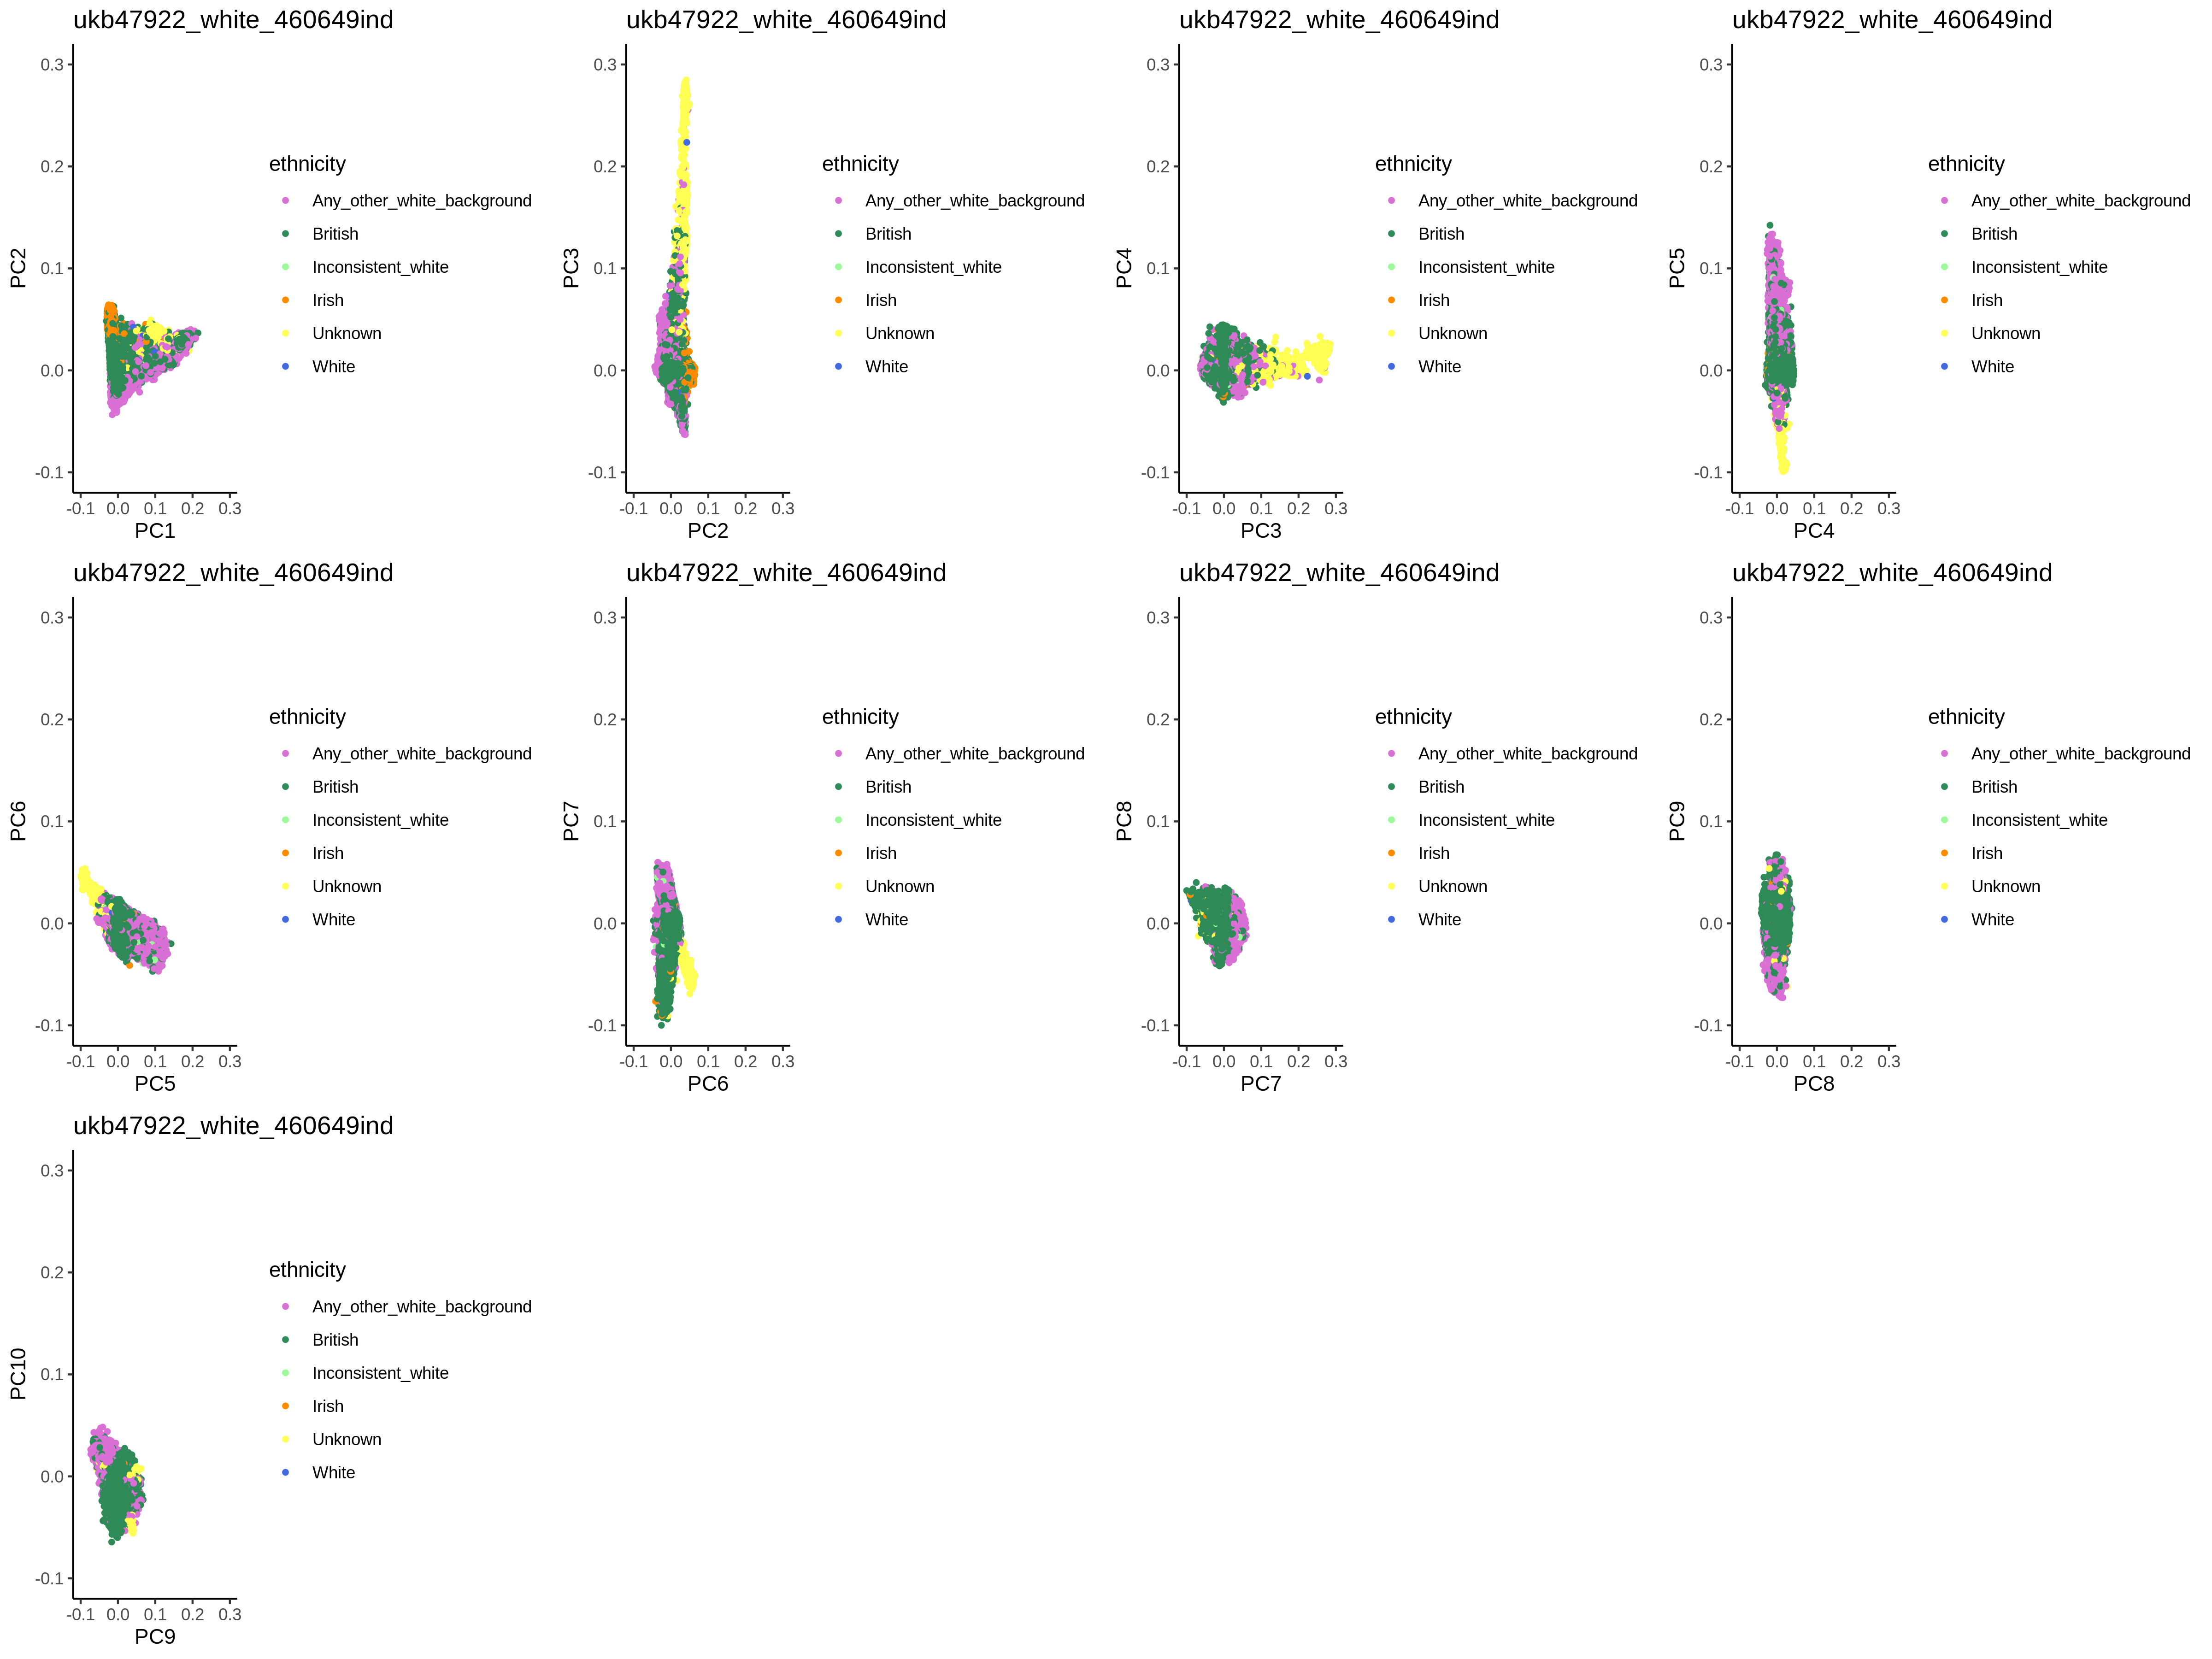

>>> /home/dmc2245/UKBiobank/results/092821_PCA_results_500K/092821_PCA_unrelated/ukb47922_white_460649ind.092821_PCA_unrelated.pca.pc.png:

bash: /home/dmc2245/UKBiobank/results/092821_PCA_results_500K/092821_PCA_unrelated/ukb47922_white_460649ind.092821_PCA_unrelated.pca.pc.png: Permission denied



In [14]:
%preview -s png /home/dmc2245/UKBiobank/results/092821_PCA_results_500K/092821_PCA_unrelated/ukb47922_white_460649ind.092821_PCA_unrelated.pca.pc.png

> /home/dmc2245/UKBiobank/results/092821_PCA_results_500K/092821_PCA_unrelated/ukb47922_white_460649ind.092821_PCA_unrelated.pca.scree.png (50.9 KiB):

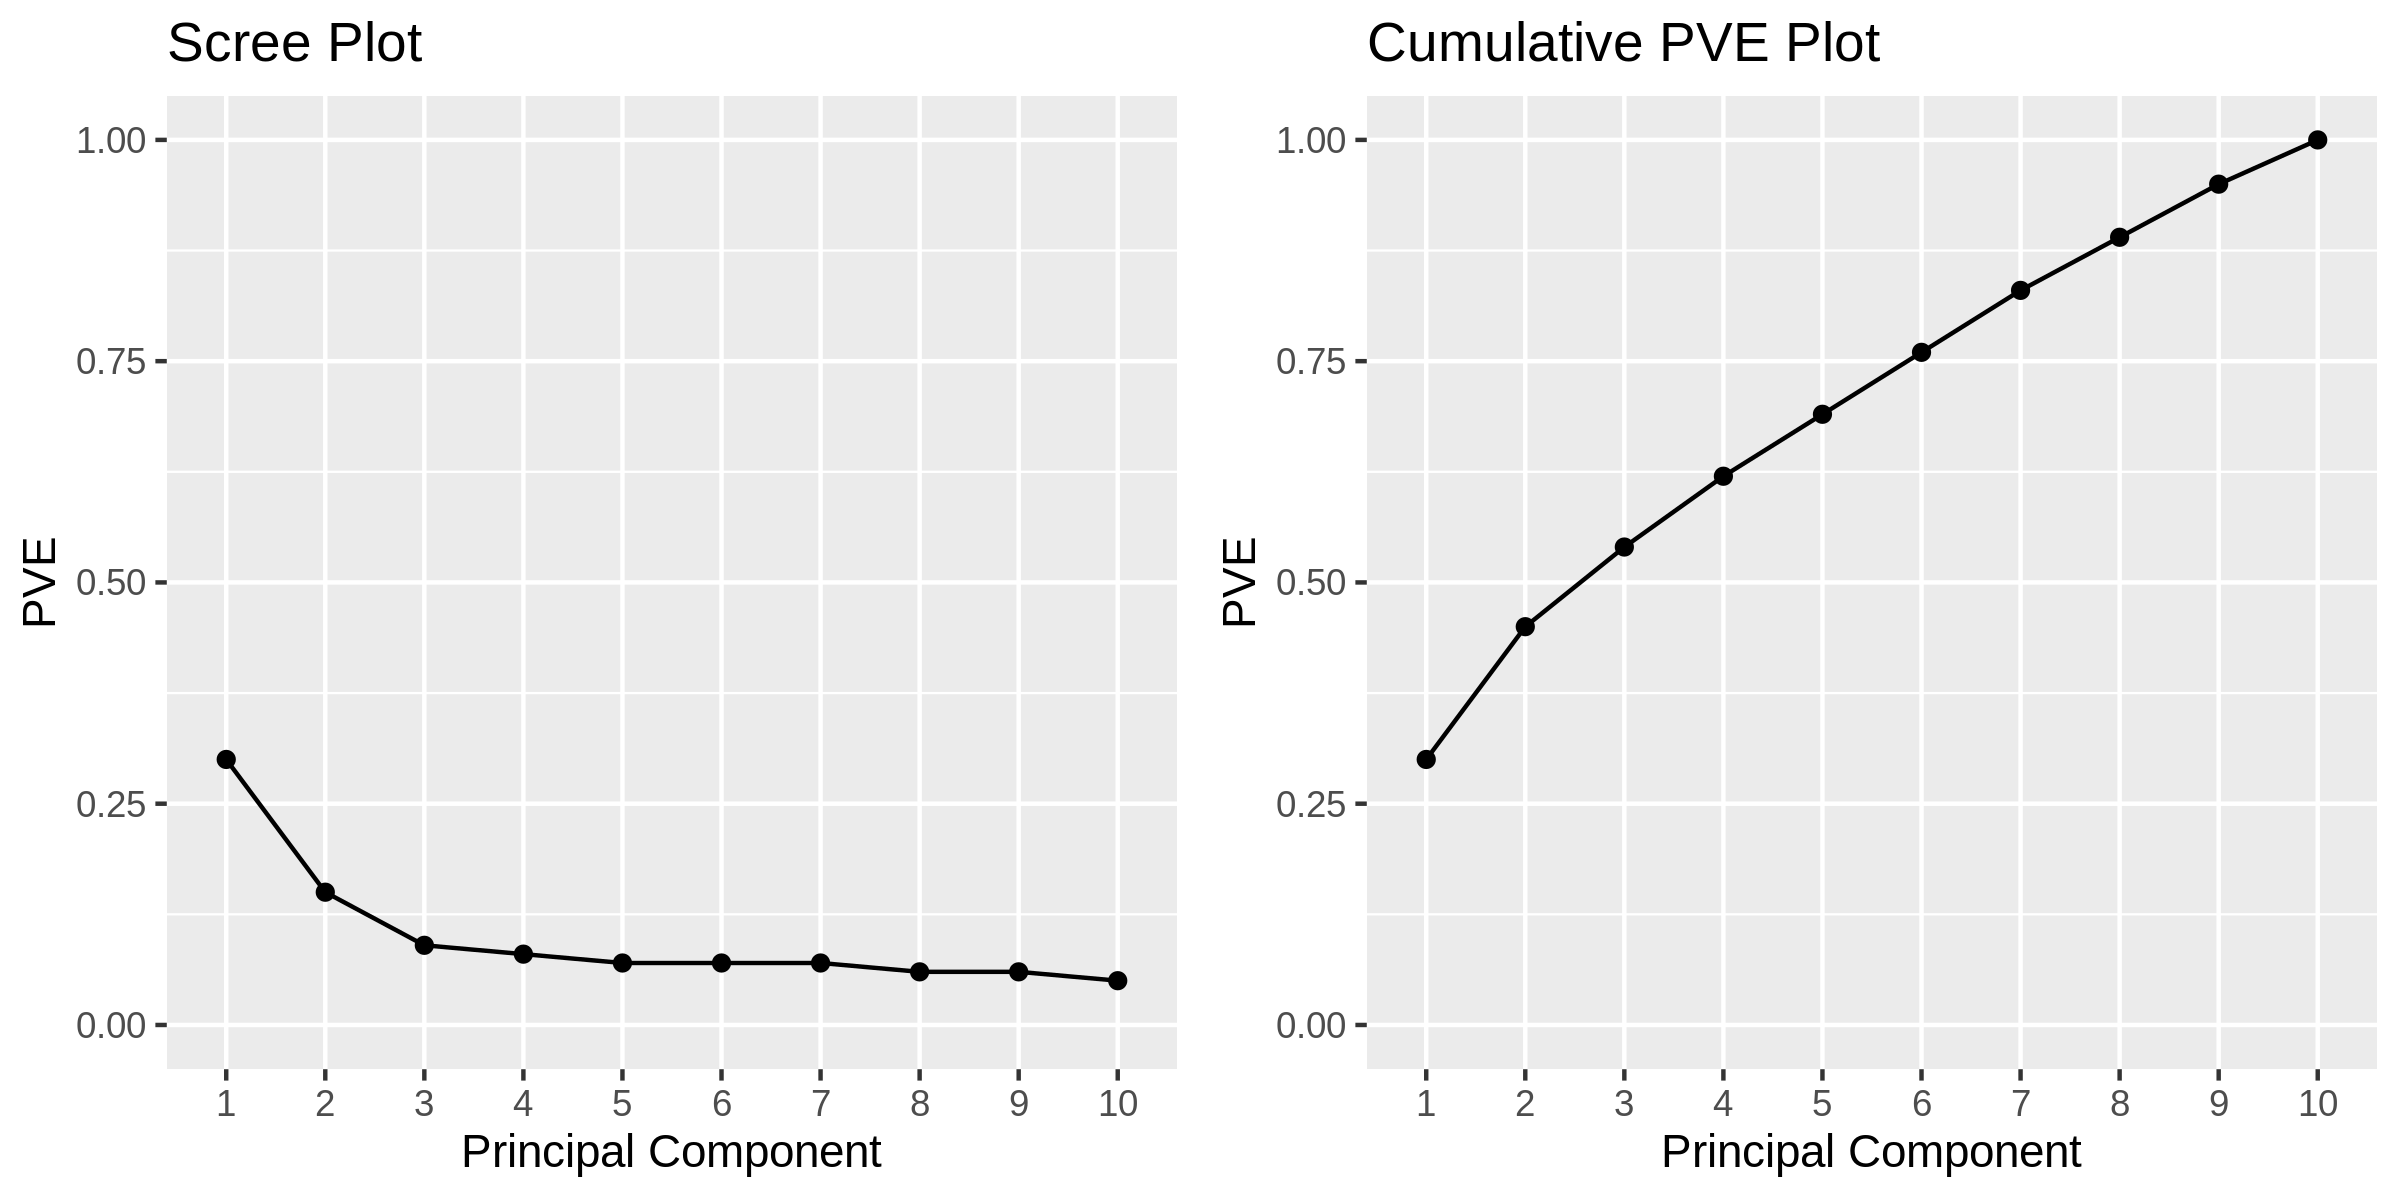

>>> /home/dmc2245/UKBiobank/results/092821_PCA_results_500K/092821_PCA_unrelated/ukb47922_white_460649ind.092821_PCA_unrelated.pca.scree.png:

bash: /home/dmc2245/UKBiobank/results/092821_PCA_results_500K/092821_PCA_unrelated/ukb47922_white_460649ind.092821_PCA_unrelated.pca.scree.png: Permission denied



In [15]:
%preview -s png /home/dmc2245/UKBiobank/results/092821_PCA_results_500K/092821_PCA_unrelated/ukb47922_white_460649ind.092821_PCA_unrelated.pca.scree.png

#### Project related samples back

In [16]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_PCA_related_pval0.005
#This is the bfile originated after filtering related individuals
genoFile=$UKBB_PATH/results/092821_PCA_results_500K/092821_ldprun_related/cache/*.filtered.extracted.bed
phenoFile=$UKBB_PATH/phenotype_files/HI_UKBB/ukb47922_white_460649ind.pheno
# Project using the PCA model for the unrelated individuals
pca_model=$UKBB_PATH/results/092821_PCA_results_500K/092821_PCA_unrelated/*.pca.rds
pca_sbatch=$USER_PATH/UKBB_GWAS_dev/output/flashpca_white_european_related_projected_pval0.005_$(date +"%Y-%m-%d").sbatch
label_col=ethnicity
pop_col=ethnicity
k=10
maha_k=10
prob=0.997
#after correcting for multiple comparissons 0.05/10PC's
pval=0.005
min_axis=""
max_axis=""
pca_sos=$USER_PATH/bioworkflows/GWAS/PCA.ipynb
## set the --homogeneous options to consider all the pops like one 

pca_args="""project_samples
    --cwd $cwd
    --genoFile $genoFile
    --phenoFile $phenoFile
    --pca_model $pca_model
    --k $k
    --maha_k $maha_k
    --label_col $label_col
    --pop_col $pop_col
    --prob $prob
    --pval $pval
    --homogeneous
    --min_axis $min_axis
    --max_axis $max_axis
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
"""

sos run ~/project/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $pca_sos \
    --to-script $pca_sbatch \
    --args "$pca_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/dmc2245/project/UKBB_GWAS_dev/output/flashpca_white_european_related_projected_pval0.005_2021-10-04.sbatch
INFO: Workflow csg (ID=w3dc97242d98cc52e) is executed successfully with 1 completed step.



#### Plot the projected individuals and highlight outliers

In [18]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_PCA_related_pval0.005
#This is the bfile originated after filtering related individuals
genoFile=$UKBB_PATH/results/092821_PCA_results_500K/092821_ldprun_related/cache/*.filtered.extracted.bed
phenoFile=$UKBB_PATH/phenotype_files/HI_UKBB/ukb47922_white_460649ind.pheno
plot_data=$UKBB_PATH/results/092821_PCA_results_500K/092821_PCA_related_pval0.005/*.pca.projected.rds
outlier_file=$UKBB_PATH/results/092821_PCA_results_500K/092821_PCA_related_pval0.005/*.outliers
label_col=ethnicity
pop_col=ethnicity
pca_sbatch=$USER_PATH/UKBB_GWAS_dev/output/plot_european_projected_$(date +"%Y-%m-%d").sbatch
job_size=1
pca_sos=$USER_PATH/bioworkflows/GWAS/PCA.ipynb

pca_args="""plot_pca
    --cwd $cwd
    --genoFile $genoFile
    --phenoFile $phenoFile
    --label_col $label_col
    --pop_col $pop_col
    --plot_data $plot_data
    --outlier_file $outlier_file
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
"""

sos run ~/project/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $pca_sos \
    --to-script $pca_sbatch \
    --args "$pca_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg (index=0) is ignored due to saved signature
INFO: csg output:   /home/dmc2245/project/UKBB_GWAS_dev/output/plot_european_projected_2021-10-04.sbatch
INFO: Workflow csg (ID=wbc5c7bd9ea7510a5) is ignored with 1 ignored step.



> /home/dmc2245/UKBiobank/results/092821_PCA_results_500K/092821_PCA_related_pval0.005/ukb47922_white_460649ind.092821_PCA_related_pval0.005.pca.projected.pc.png (433.4 KiB):

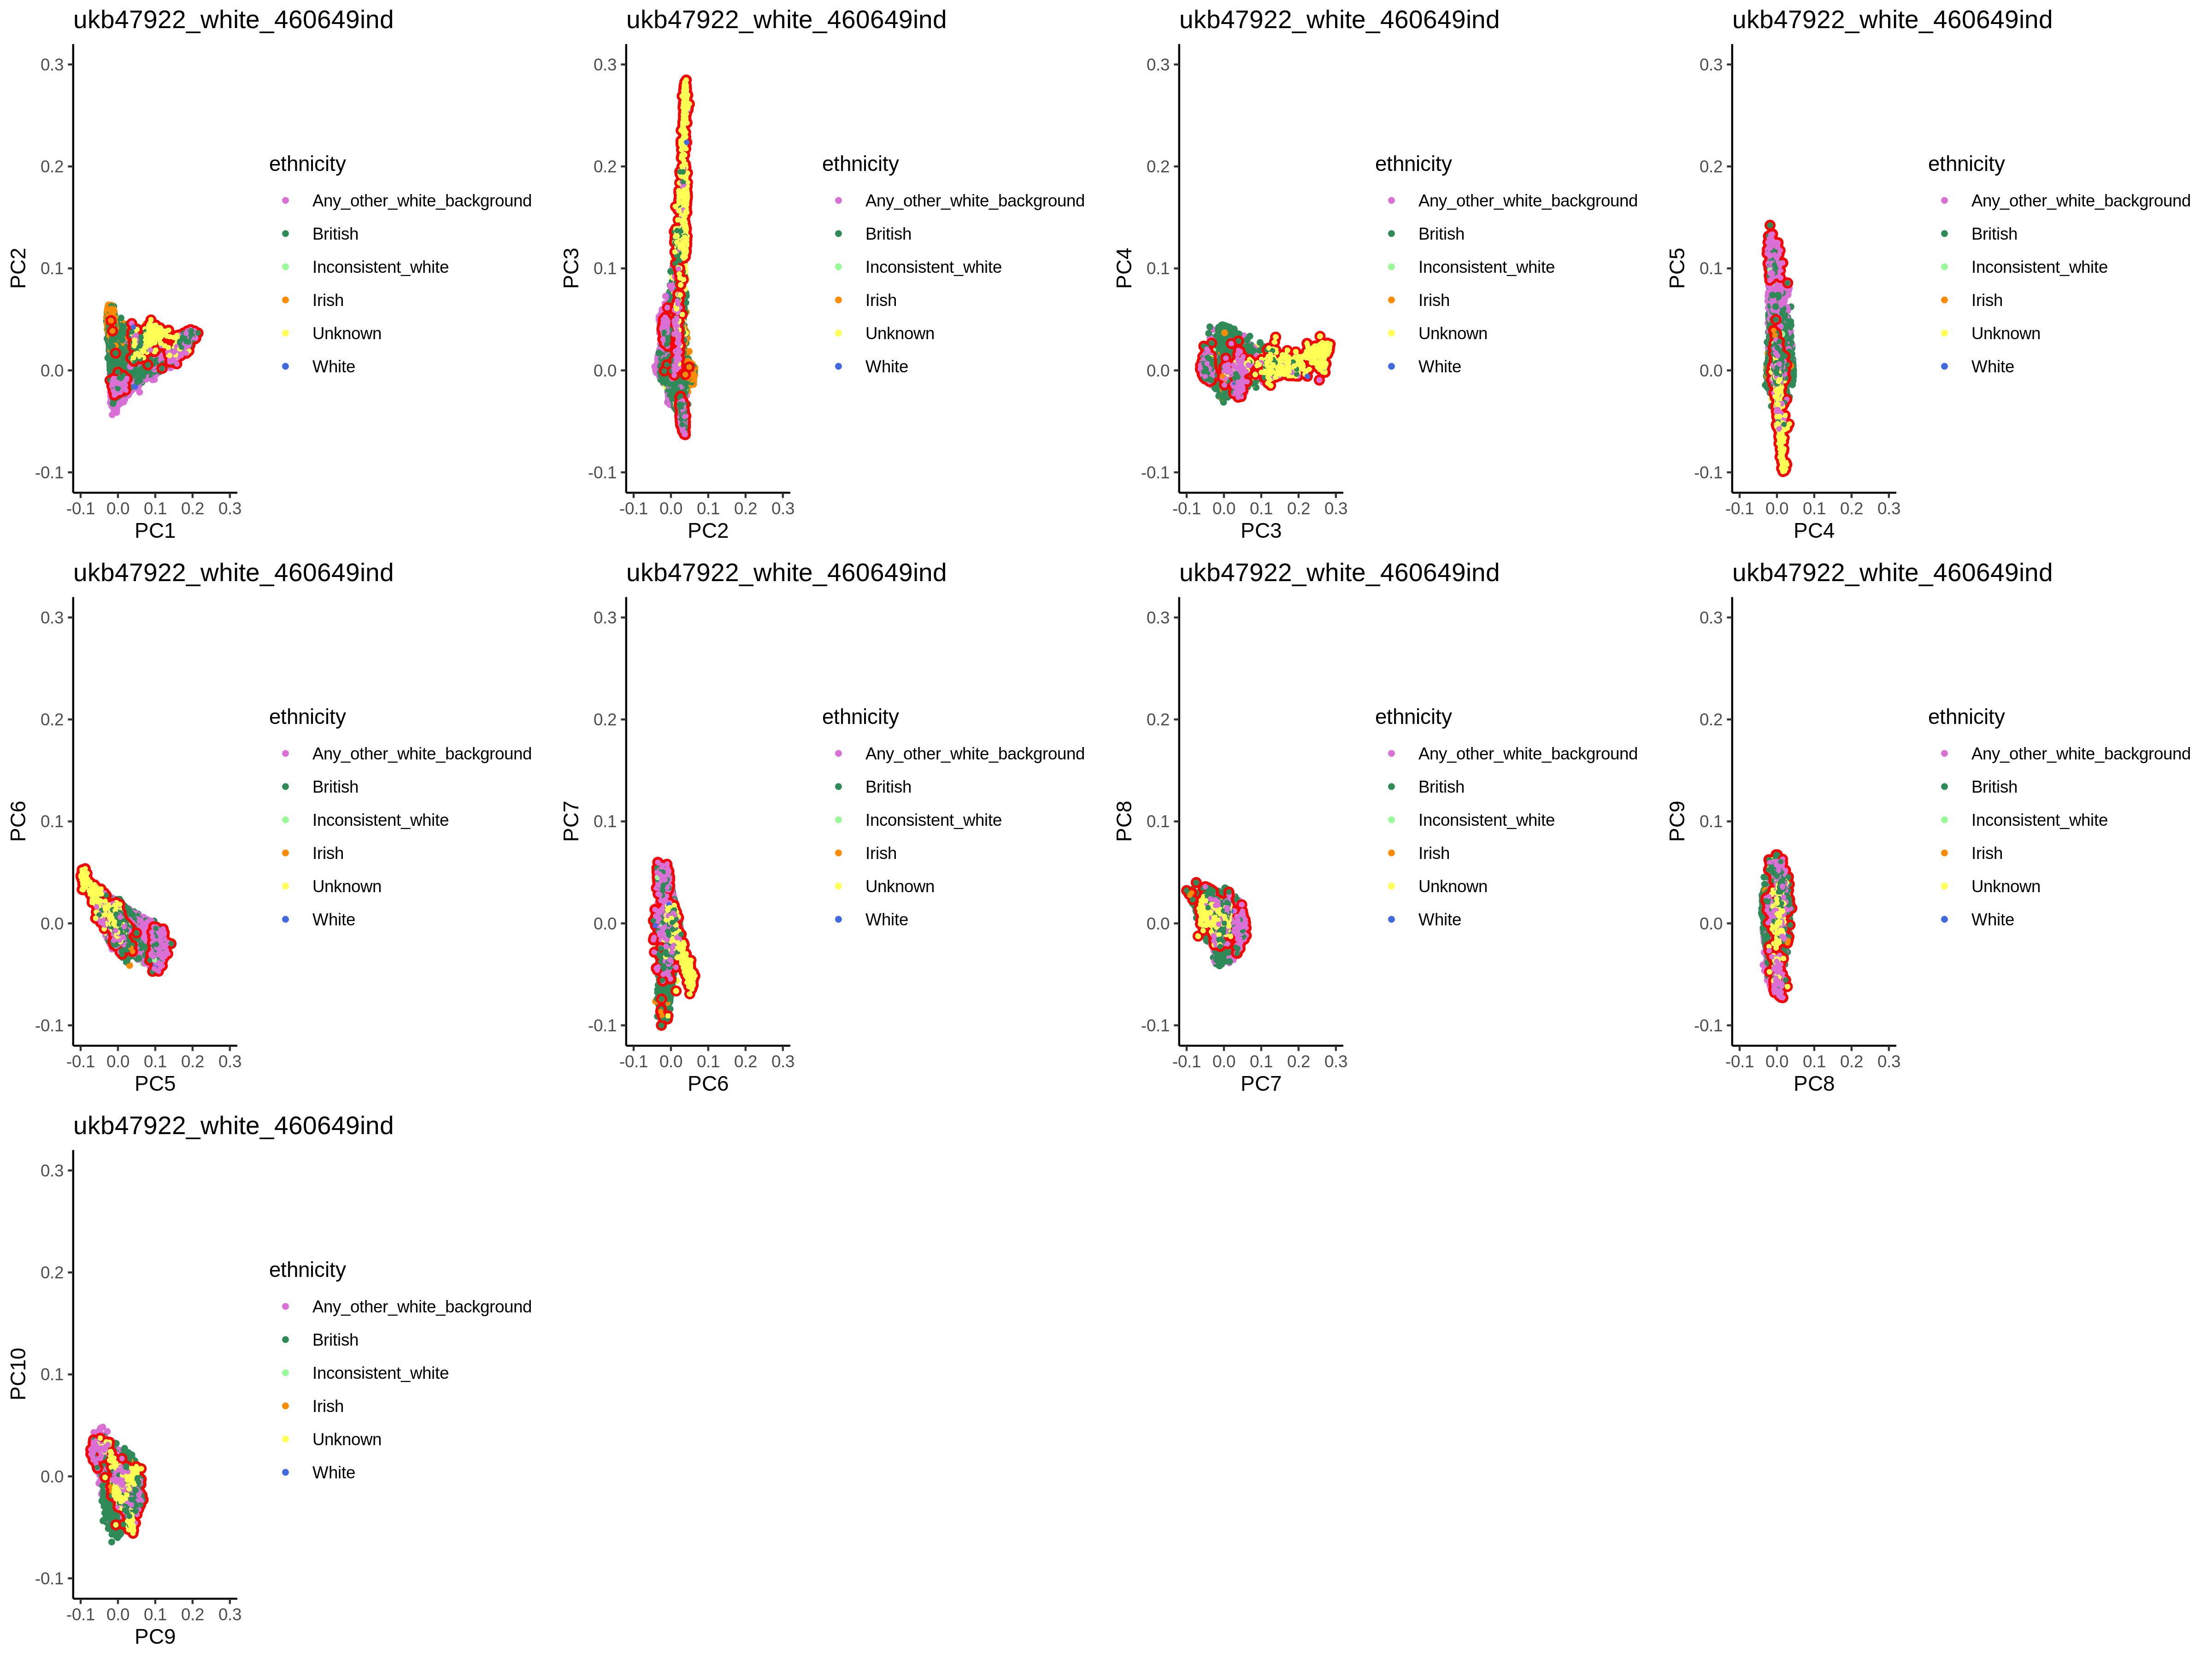

>>> /home/dmc2245/UKBiobank/results/092821_PCA_results_500K/092821_PCA_related_pval0.005/ukb47922_white_460649ind.092821_PCA_related_pval0.005.pca.projected.pc.png:

bash: /home/dmc2245/UKBiobank/results/092821_PCA_results_500K/092821_PCA_related_pval0.005/ukb47922_white_460649ind.092821_PCA_related_pval0.005.pca.projected.pc.png: Permission denied



In [19]:
%preview -s png /home/dmc2245/UKBiobank/results/092821_PCA_results_500K/092821_PCA_related_pval0.005/ukb47922_white_460649ind.092821_PCA_related_pval0.005.pca.projected.pc.png

## Get the phenotype files using the 092821_hearing_impairment_500K notebook

These phenotypes were created with the `~/UKBB_GWAS_dev/analysis/phenotypes/092821_hearing_impairment_500K.ipynb` notebook

## Calculate the first 2 PC's for each of these phenotypes to run the association analysis with the imputed data

### f.3393

#### Step 1

In [6]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_f3393_pca_500K_imputed
#gwas_sbatch=$USER_PATH/UKBB_GWAS_dev/output/qc1_f3393_qcarray_$(date +"%Y-%m-%d").sbatch
gwas_sbatch=~/hearing/qc1_f3393_qcarray_$(date +"%Y-%m-%d").sbatch
## Use qc'ed genotype array
genoFile=$UKBB_PATH/genotype_files_processed/090221_sample_variant_qc_final_callrate90/cache/UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.bed
keep_samples=$UKBB_PATH/results/092821_PCA_results_500K/100521_UKBB_Hearing_aid_f3393_expandedwhite_15601cases_237318ctrl_500k.keep_id
#Keep variants after LD pruning
keep_variants=$UKBB_PATH/results/092821_PCA_results_500K/092821_ldprun_unrelated/cache/*092821_ldprun_unrelated.filtered.prune.in

#GWAS QC variables set all of this variables to 0 to avoid doing more filtering
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
numThreads=1
mem='30G'

gwasqc_sos=$USER_PATH/bioworkflows/GWAS/GWAS_QC.ipynb

gwasqc_args="""qc:1
    --cwd $cwd
    --genoFile $genoFile
    --keep_samples $keep_samples
    --keep_variants $keep_variants
    --maf_filter $maf_filter
    --geno_filter $geno_filter
    --hwe_filter $hwe_filter
    --mind_filter $mind_filter
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
    --mem $mem
"""

sos run $USER_PATH/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $gwasqc_sos \
    --to-script $gwas_sbatch \
    --args "$gwasqc_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/tf2478/hearing/qc1_f3393_qcarray_2021-10-05.sbatch
INFO: Workflow csg (ID=w481c1edb7172184e) is executed successfully with 1 completed step.


#### Step 2.

In [21]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_f3393_pca_500K_imputed
#This is the bfile obtained in step 1
genoFile=$UKBB_PATH/results/092821_PCA_results_500K/092821_f3393_pca_500K_imputed/cache/*.bed
# Format FID, IID, pop
phenoFile=$UKBB_PATH/results/092821_PCA_results_500K/100521_UKBB_Hearing_aid_f3393_expandedwhite_15601cases_237318ctrl_500k.phenopca
label_col=ethnicity
pop_col=ethnicity
pca_sbatch=~/hearing/flashpca_f3393_pc_$(date +"%Y-%m-%d").sbatch
k=2
min_axis=""
max_axis=""

pca_sos=$USER_PATH/bioworkflows/GWAS/PCA.ipynb

pca_args="""flashpca
    --cwd $cwd
    --genoFile $genoFile
    --phenoFile $phenoFile
    --k $k
    --label_col $label_col
    --pop_col $pop_col
    --min_axis $min_axis
    --max_axis $max_axis
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
"""

sos run $USER_PATH/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $pca_sos \
    --to-script $pca_sbatch \
    --args "$pca_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/tf2478/hearing/flashpca_f3393_pc_2021-10-05.sbatch
INFO: Workflow csg (ID=w6363549e291ad4ec) is executed successfully with 1 completed step.


### f.2247

#### Step 1

In [10]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_f2247_pca_500K_imputed
#gwas_sbatch=$USER_PATH/UKBB_GWAS_dev/output/qc1_f2247_qcarray_$(date +"%Y-%m-%d").sbatch
gwas_sbatch=~/hearing/qc1_f2247_qcarray_$(date +"%Y-%m-%d").sbatch
## Use qc'ed genotype array
genoFile=$UKBB_PATH/genotype_files_processed/090221_sample_variant_qc_final_callrate90/cache/UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.bed
keep_samples=$UKBB_PATH/results/092821_PCA_results_500K/100521_UKBB_Hearing_difficulty_f2247_expandedwhite_110453cases_237318ctrl_500k.keep_id
#Keep variants after LD pruning
keep_variants=$UKBB_PATH/results/092821_PCA_results_500K/092821_ldprun_unrelated/cache/*092821_ldprun_unrelated.filtered.prune.in

#GWAS QC variables set all of this variables to 0 to avoid doing more filtering
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
numThreads=1
mem='30G'

gwasqc_sos=$USER_PATH/bioworkflows/GWAS/GWAS_QC.ipynb

gwasqc_args="""qc:1
    --cwd $cwd
    --genoFile $genoFile
    --keep_samples $keep_samples
    --keep_variants $keep_variants
    --maf_filter $maf_filter
    --geno_filter $geno_filter
    --hwe_filter $hwe_filter
    --mind_filter $mind_filter
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
    --mem $mem
"""

sos run $USER_PATH/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $gwasqc_sos \
    --to-script $gwas_sbatch \
    --args "$gwasqc_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg (index=0) is ignored due to saved signature
INFO: csg output:   /home/tf2478/hearing/qc1_f2247_qcarray_2021-10-05.sbatch
INFO: Workflow csg (ID=w9b681ba68168968a) is ignored with 1 ignored step.


#### Step 2.

In [22]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_f2247_pca_500K_imputed
#This is the bfile obtained in step 1
genoFile=$UKBB_PATH/results/092821_PCA_results_500K/092821_f2247_pca_500K_imputed/cache/*.bed
# Format FID, IID, pop
phenoFile=$UKBB_PATH/results/092821_PCA_results_500K/100521_UKBB_Hearing_difficulty_f2247_expandedwhite_110453cases_237318ctrl_500k.phenopca
label_col=ethnicity
pop_col=ethnicity
pca_sbatch=~/hearing/flashpca_f2247_pc_$(date +"%Y-%m-%d").sbatch
k=2
min_axis=""
max_axis=""

pca_sos=$USER_PATH/bioworkflows/GWAS/PCA.ipynb

pca_args="""flashpca
    --cwd $cwd
    --genoFile $genoFile
    --phenoFile $phenoFile
    --k $k
    --label_col $label_col
    --pop_col $pop_col
    --min_axis $min_axis
    --max_axis $max_axis
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
"""

sos run  $USER_PATH/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $pca_sos \
    --to-script $pca_sbatch \
    --args "$pca_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/tf2478/hearing/flashpca_f2247_pc_2021-10-05.sbatch
INFO: Workflow csg (ID=we0e8f7925eba0448) is executed successfully with 1 completed step.


### f.2257

#### Step 1

In [11]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_f2257_pca_500K_imputed
#gwas_sbatch=$USER_PATH/UKBB_GWAS_dev/output/qc1_f2257_qcarray_$(date +"%Y-%m-%d").sbatch
gwas_sbatch=~/hearing/qc1_f2257_qcarray_$(date +"%Y-%m-%d").sbatch
## Use qc'ed genotype array
genoFile=$UKBB_PATH/genotype_files_processed/090221_sample_variant_qc_final_callrate90/cache/UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.bed
keep_samples=$UKBB_PATH/results/092821_PCA_results_500K/100521_UKBB_Hearing_noise_f2257_expandedwhite_161443cases_237318ctrl_500k.keep_id
#Keep variants after LD pruning
keep_variants=$UKBB_PATH/results/092821_PCA_results_500K/092821_ldprun_unrelated/cache/*092821_ldprun_unrelated.filtered.prune.in

#GWAS QC variables set all of this variables to 0 to avoid doing more filtering
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
numThreads=1
mem='30G'

gwasqc_sos=$USER_PATH/bioworkflows/GWAS/GWAS_QC.ipynb

gwasqc_args="""qc:1
    --cwd $cwd
    --genoFile $genoFile
    --keep_samples $keep_samples
    --keep_variants $keep_variants
    --maf_filter $maf_filter
    --geno_filter $geno_filter
    --hwe_filter $hwe_filter
    --mind_filter $mind_filter
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
    --mem $mem
"""

sos run $USER_PATH/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $gwasqc_sos \
    --to-script $gwas_sbatch \
    --args "$gwasqc_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/tf2478/hearing/qc1_f2257_qcarray_2021-10-05.sbatch
INFO: Workflow csg (ID=wfea9b927b2776c49) is executed successfully with 1 completed step.


#### Step 2.

In [23]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_f2257_pca_500K_imputed
#This is the bfile obtained in step 1
genoFile=$UKBB_PATH/results/092821_PCA_results_500K/092821_f2257_pca_500K_imputed/cache/*.bed
# Format FID, IID, pop
phenoFile=$UKBB_PATH/results/092821_PCA_results_500K/100521_UKBB_Hearing_noise_f2257_expandedwhite_161443cases_237318ctrl_500k.phenopca
label_col=ethnicity
pop_col=ethnicity
pca_sbatch=~/hearing/flashpca_f2257_pc_$(date +"%Y-%m-%d").sbatch
k=2
min_axis=""
max_axis=""

pca_sos=$USER_PATH/bioworkflows/GWAS/PCA.ipynb

pca_args="""flashpca
    --cwd $cwd
    --genoFile $genoFile
    --phenoFile $phenoFile
    --k $k
    --label_col $label_col
    --pop_col $pop_col
    --min_axis $min_axis
    --max_axis $max_axis
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
"""

sos run  $USER_PATH/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $pca_sos \
    --to-script $pca_sbatch \
    --args "$pca_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/tf2478/hearing/flashpca_f2257_pc_2021-10-05.sbatch
INFO: Workflow csg (ID=w83bd6209ddc24f64) is executed successfully with 1 completed step.


### Combined f.2247 & f.2257

#### Step 1

In [12]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_f2247_f2257_pca_500K_imputed
#gwas_sbatch=$USER_PATH/UKBB_GWAS_dev/output/qc1_f2247_f2257_qcarray_$(date +"%Y-%m-%d").sbatch
gwas_sbatch=~/hearing/qc1_f2247_f2257_qcarray_$(date +"%Y-%m-%d").sbatch
## Use qc'ed genotype array
genoFile=$UKBB_PATH/genotype_files_processed/090221_sample_variant_qc_final_callrate90/cache/UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.bed
keep_samples=$UKBB_PATH/results/092821_PCA_results_500K/100521_UKBB_Combined_f2247_f2257_expandedwhite_93258cases_237318ctrl_500k.keep_id
#Keep variants after LD pruning
keep_variants=$UKBB_PATH/results/092821_PCA_results_500K/092821_ldprun_unrelated/cache/*092821_ldprun_unrelated.filtered.prune.in

#GWAS QC variables set all of this variables to 0 to avoid doing more filtering
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
numThreads=1
mem='30G'

gwasqc_sos=$USER_PATH/bioworkflows/GWAS/GWAS_QC.ipynb

gwasqc_args="""qc:1
    --cwd $cwd
    --genoFile $genoFile
    --keep_samples $keep_samples
    --keep_variants $keep_variants
    --maf_filter $maf_filter
    --geno_filter $geno_filter
    --hwe_filter $hwe_filter
    --mind_filter $mind_filter
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
    --mem $mem
"""

sos run $USER_PATH/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $gwasqc_sos \
    --to-script $gwas_sbatch \
    --args "$gwasqc_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/tf2478/hearing/qc1_f2247_f2257_qcarray_2021-10-05.sbatch
INFO: Workflow csg (ID=w8e0d9b17c271ad03) is executed successfully with 1 completed step.


#### Step 2.

In [24]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_f2247_f2257_pca_500K_imputed
#This is the bfile obtained in step 1
genoFile=$UKBB_PATH/results/092821_PCA_results_500K/092821_f2247_f2257_pca_500K_imputed/cache/*.bed
# Format FID, IID, pop
phenoFile=$UKBB_PATH/results/092821_PCA_results_500K/100521_UKBB_Combined_f2247_f2257_expandedwhite_93258cases_237318ctrl_500k.phenopca
label_col=ethnicity
pop_col=ethnicity
pca_sbatch=~/hearing/flashpca_f2247_f2257_pc_$(date +"%Y-%m-%d").sbatch
k=2
min_axis=""
max_axis=""

pca_sos=$USER_PATH/bioworkflows/GWAS/PCA.ipynb

pca_args="""flashpca
    --cwd $cwd
    --genoFile $genoFile
    --phenoFile $phenoFile
    --k $k
    --label_col $label_col
    --pop_col $pop_col
    --min_axis $min_axis
    --max_axis $max_axis
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
"""

sos run  $USER_PATH/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $pca_sos \
    --to-script $pca_sbatch \
    --args "$pca_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/tf2478/hearing/flashpca_f2247_f2257_pc_2021-10-05.sbatch
INFO: Workflow csg (ID=wd222067c2307ccef) is executed successfully with 1 completed step.


### Mendelian

#### Step 1

In [13]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_mendelian_pca_500K_imputed
#gwas_sbatch=$USER_PATH/UKBB_GWAS_dev/output/qc1_mendelian_qcarray_$(date +"%Y-%m-%d").sbatch
gwas_sbatch=~/hearing/qc1_mendelian_qcarray_$(date +"%Y-%m-%d").sbatch
## Use qc'ed genotype array
genoFile=$UKBB_PATH/genotype_files_processed/090221_sample_variant_qc_final_callrate90/cache/UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.bed
keep_samples=$UKBB_PATH/results/092821_PCA_results_500K/100521_UKBB_Mendelian_expandedwhite_6824cases_237318ctrl_500k.keep_id
#Keep variants after LD pruning
keep_variants=$UKBB_PATH/results/092821_PCA_results_500K/092821_ldprun_unrelated/cache/*092821_ldprun_unrelated.filtered.prune.in

#GWAS QC variables set all of this variables to 0 to avoid doing more filtering
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
numThreads=1
mem='30G'

gwasqc_sos=$USER_PATH/bioworkflows/GWAS/GWAS_QC.ipynb

gwasqc_args="""qc:1
    --cwd $cwd
    --genoFile $genoFile
    --keep_samples $keep_samples
    --keep_variants $keep_variants
    --maf_filter $maf_filter
    --geno_filter $geno_filter
    --hwe_filter $hwe_filter
    --mind_filter $mind_filter
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
    --mem $mem
"""

sos run $USER_PATH/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg \
    --template-file $tpl_file \
    --workflow-file $gwasqc_sos \
    --to-script $gwas_sbatch \
    --args "$gwasqc_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/tf2478/hearing/qc1_mendelian_qcarray_2021-10-05.sbatch
INFO: Workflow csg (ID=we22201f05e2a34b9) is executed successfully with 1 completed step.


#### Step 2.

In [25]:
## Columbia's cluster
cwd=$UKBB_PATH/results/092821_PCA_results_500K/092821_mendelian_pca_500K_imputed
#This is the bfile obtained in step 1
genoFile=$UKBB_PATH/results/092821_PCA_results_500K/092821_mendelian_pca_500K_imputed/cache/*.bed
# Format FID, IID, pop
phenoFile=$UKBB_PATH/results/092821_PCA_results_500K/100521_UKBB_Mendelian_expandedwhite_6824cases_237318ctrl_500k.phenopca
label_col=ethnicity
pop_col=ethnicity
pca_sbatch=~/hearing/flashpca_mendelian_pc_$(date +"%Y-%m-%d").sbatch
k=2
min_axis=""
max_axis=""

pca_sos=$USER_PATH/bioworkflows/GWAS/PCA.ipynb

pca_args="""flashpca
    --cwd $cwd
    --genoFile $genoFile
    --phenoFile $phenoFile
    --k $k
    --label_col $label_col
    --pop_col $pop_col
    --min_axis $min_axis
    --max_axis $max_axis
    --numThreads $numThreads 
    --job_size $job_size
    --container_lmm $container_lmm
"""

sos run  $USER_PATH/UKBB_GWAS_dev/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $pca_sos \
    --to-script $pca_sbatch \
    --args "$pca_args"

INFO: Running csg: Configuration for Columbia csg partition cluster
INFO: csg is completed.
INFO: csg output:   /home/tf2478/hearing/flashpca_mendelian_pc_2021-10-05.sbatch
INFO: Workflow csg (ID=we78148acaedae51b) is executed successfully with 1 completed step.


## Run association analysis with imputed data for each phenotype

In [ ]:
lmm_dir_regenie=$lmm_imp_dir_regenie/$(date +"%Y-%m-%d")_f3393_500K
lmm_sbatch_regenie=$USER_PATH/UKBB_GWAS_dev/output/f3393_hearing_aid_impdata_regenie_$(date +"%Y-%m-%d").sbatch
phenoFile=$hearing_pheno_path/
covarFile=$hearing_pheno_path/
phenoCol=f3393
covarCol=sex
qCovarCol="age PC1 PC2"
genoFile=`echo $UKBB_PATH/genotype_files/ukb39554_imputeddataset/ukb_imp_chr{1..22}_v3.bgen`
sampleFile=$UKBB_PATH/genotype_files/ukb39554_imputeddataset/ukb32285_imputedindiv.sample
bgenMinINFO=0.8
bgenMinMAF=0.001
minMAC=4
maf_filter=0
geno_filter=0
hwe_filter=0
mind_filter=0
#Use the original bed files for the genotype array on regenie step1
genoFile=~/UKBiobank/genotype_files_processed/090221_sample_variant_qc_final_callrate90/cache/UKB_genotypedatadownloaded083019.090221_sample_variant_qc_final_callrate90.filtered.extracted.bed

lmm_args="""regenie
    --cwd $lmm_dir_regenie 
    --bfile $bfile 
    --genoFile $genoFile
    --sampleFile $sampleFile
    --phenoFile $phenoFile 
    --formatFile $formatFile_regenie 
    --phenoCol $phenoCol
    --covarCol $covarCol  
    --qCovarCol $qCovarCol
    --bsize $bsize
    --lowmem_dir $lowmem_dir
    --trait $trait 
    --bgenMinMAF $bgenMinMAF 
    --bgenMinINFO $bgenMinINFO
    --maf_filter $maf_filter
    --geno_filter $geno_filter
    --hwe_filter $hwe_filter
    --mind_filter $mind_filter
    --minMAC $minMAC
    --job_size $lmm_job_size
    --ylim $ylim
    --reverse_log_p $reverse_log_p
    --numThreads $numThreads
    --container_lmm $container_lmm
    --container_marp $container_marp
"""

sos run ~/project/bioworkflows/admin/Get_Job_Script.ipynb csg\
    --template-file $tpl_file \
    --workflow-file $lmm_sos \
    --to-script $lmm_sbatch_regenie \
    --args "$lmm_args"

## Use Yin's pipeline to:

1. Do liftover of the GRhC 37 coordinates of the imputed data to GRhC 38
2. Merge imputed and exome genotype data
3. Do fine mapping analysis. 